# A2C (Advantage Actor-Critic)

Advantage Actor-Critic is an on-policy value-policy algorithm with bootstraps.
It exploits the fact that subtracting a "baseline" $b$ doesn't affect expectation of policy gradient.

$$
\nabla \mathbb{E}_{s,a\leftarrow \pi_{\theta}}[G(s, a)] = \mathbb{E}[G(s,a) * log(\nabla \pi_{\theta})] = \mathbb{E}[(G(s,a) - b) * \nabla log( \pi_{\theta})]
$$

A2C uses $b=v(s_t)$ and $G(s,a)=q(s,a)$

$$
\nabla \mathbb{E}_{s,a\leftarrow \pi_{\theta}}[G(s, a)] = \mathbb{E}_{s,a\leftarrow \pi_{\theta}}[(q(s,a) - v(s)) * \nabla log( \pi_{\theta})]
$$

It can be shown that $q(s_t, a_t)$ can be estimated with $r_{t+1}+\gamma*v_{t+1}$, because $q$ is expected reward conditioned on action $a_t$

$$
\nabla \mathbb{E}_{s,a\leftarrow \pi_{\theta}}[G(s, a)] = \mathbb{E}_{s,a\leftarrow \pi_{\theta}}[(r_{t+1} + \gamma*v(s_{t+1}) - v(s)) * \nabla log( \pi_{\theta})]
$$

From Bellman`s expectation equation we can produce TD(0) targets under the current policy:
$$
\hat{v_t}=r_{t+1}+\gamma*v_{t+1}
$$

Value loss component can be estimated with

$$
$MSE(v_t, \hat v_t)= ([[r_{t+1}+\gamma*v_{t+1}]] - v_t)^2
$$
where double brackets prevent gradient flow.

Additionally an entropy component of gradient can be used to regularize the policy. We want to keep high policy entropy to reduce policy overfitting.
$$
\mathcal{L}_h=-H(\pi_{\theta}(s))
$$

Combining all three gradient components gives us the following stochastic gradient:
$$
\nabla_{\theta}\mathcal{L}=[[r_{t+1} + \gamma*v(s_{t+1}) - v(s)]] * \nabla_{\theta} log( \pi_{\theta}) + \nabla_{\theta}([[r_{t+1}+\gamma*v_w(s_{t+1})]] - v_w(s_t))^2 + \beta*\nabla_{\theta} \sum_a \pi_{\theta}(s|a)*log(\pi_{\theta}(s|a))
$$

## Links
* [2016 Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/pdf/1602.01783.pdf)

In [33]:
import gym
import numpy as np
import torch
from tqdm.notebook import tqdm


class PolicyValueModel(torch.nn.Module):

    def __init__(self, state_size, action_size, hidden_size):
        super().__init__()
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(state_size, hidden_size),
            torch.nn.SiLU(),
        )
        self.policy_nn = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, action_size),
            torch.nn.Softmax(dim=0)
        )
        self.value_nn = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):
        if type(state) is not torch.Tensor:
            state = torch.tensor(state)
        hidden = self.nn(state)
        return self.policy_nn(hidden), self.value_nn(hidden)


model = PolicyValueModel(2, 2, 4)
model.forward([1, 2.])

(tensor([0.3137, 0.6863], grad_fn=<SoftmaxBackward0>),
 tensor([0.1157], grad_fn=<AddBackward0>))

In [108]:
with gym.make("CartPole-v1", render_mode=None) as env:
    model = PolicyValueModel(env.observation_space.shape[0], env.action_space.n, 256)
    model.train()
    optimizer = torch.optim.Adam(model.parameters())

    global_step = 0
    train_every_step = 32
    gamma = 0.9
    beta = 0.1
    trace = []
    progress = tqdm(range(2000))
    losses = []
    loss_factors = []
    episode_lengths = []
    total_rewards = []
    for episode in progress:
        state = env.reset()
        total_rewards.append(0)
        for step in range(10000):
            action_dist, value = model.forward(state)
            action = torch.distributions.Categorical(action_dist).sample().item()
            new_state, reward, done, _ = env.step(action)
            if len(trace) > 0:
                trace[-1]['new_state_value'] = value

            total_rewards[-1] += reward
            trace.append({
                'state': state,
                'state_value': value,
                'action_dist': action_dist,
                'action': action,
                'reward': reward,
                'new_state': new_state,
                'done': done
            })

            state = new_state

            if len(trace) == train_every_step or done:
                if not done:
                    trace = trace[:-1]
                # print('train', trace)

                # Calculate advantages. E(Q_t) - E(V_t) ~ R_{t+1} + gamma*E(V_{t+1}) - E(V_t)
                advantages = []
                for t in trace:
                    if not t['done']:
                        advantages.append((t['reward'] + gamma * t['new_state_value'] - t['state_value']).detach().item())
                    else:
                        advantages.append((t['reward'] - t['state_value']).detach().item())
                advantages = torch.tensor(advantages)
                # print('a', advantages)
                # value update MSE error for gradient **descent** = ({t['reward'] + gamma * t['new_state_value']} - t['state_value'])^2
                #                       grad(value) = ({t['reward'] + gamma * t['new_state_value']} - t['state_value'])*grad(-t['state_value'])
                #                                   = -advantage * grad(t['state_value'])
                #
                values = torch.concat([t['state_value'] for t in trace])
                value_loss = -(advantages * values).mean()

                # policy update for gradient **ascent** = -advantage * log(t['action_dist'][t['action']]))
                action_probs = torch.stack([t['action_dist'][t['action']] for t in trace])
                policy_loss = (-advantages * torch.log(action_probs)).mean()

                # policy entropy regularization loss = beta * (-H(action_dist))
                entropies = torch.stack([(-t['action_dist'] * torch.log(t['action_dist'])).sum() for t in trace])
                entropy_loss = -beta * entropies.mean()

                # print(value_loss.shape, policy_loss.shape, entropy_loss.shape)
                # print(value_loss, policy_loss, entropy_loss)
                loss = value_loss + policy_loss + entropy_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                loss_factors.append((value_loss.item(), policy_loss.item(), entropy_loss.item()))

                trace = []
            if done:
                episode_lengths.append(step)
                break
            global_step += 1

        if np.mean(total_rewards[-100:]) > 300:
            print('Early stopping!')
            break
        progress.set_description(f'loss:{np.mean(losses[-100:]):06.3f}; episode len:{np.mean(episode_lengths[-100:]):06.0f}; total reward:{np.mean(total_rewards[-100:]):06.0f}')


/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/2000 [00:00<?, ?it/s]

Early stopping!


Text(0.5, 1.0, 'Policy entropy loss')

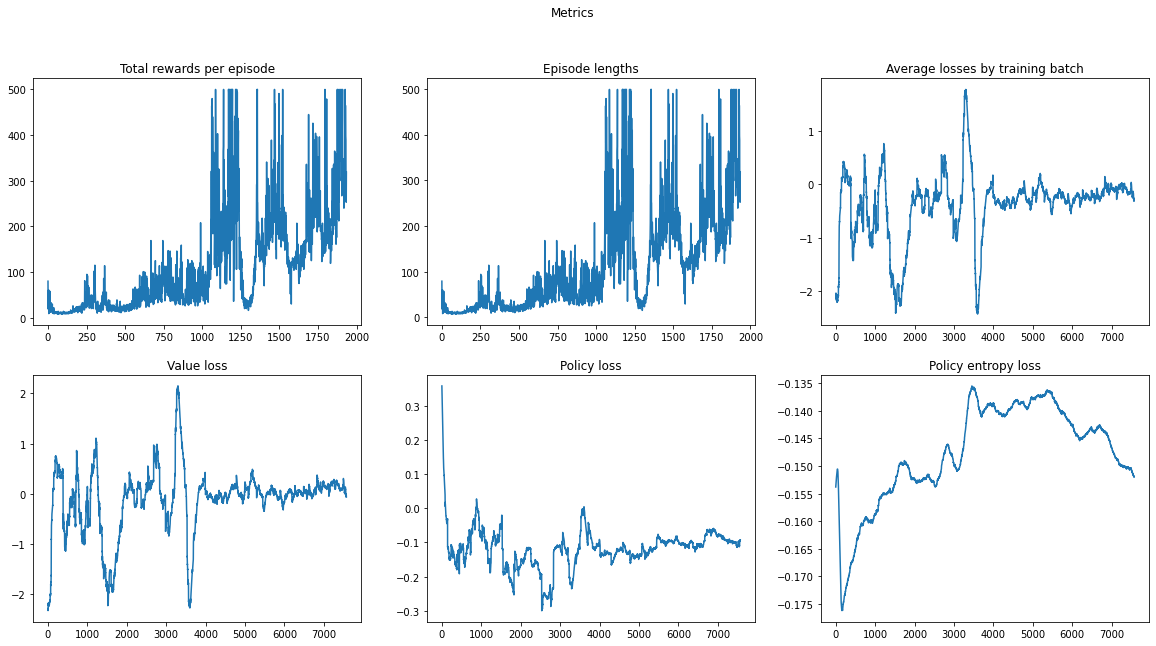

In [109]:
from matplotlib import pyplot as plt


fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Metrics')
axs[0, 0].plot(total_rewards)
axs[0, 0].set_title("Total rewards per episode")
axs[0, 1].plot(episode_lengths)
axs[0, 1].set_title("Episode lengths")
axs[0, 2].plot(np.convolve(losses, [1/100] * 300, mode='valid'))
axs[0, 2].set_title("Average losses by training batch")

axs[1, 0].plot(np.convolve([lf[0] for lf in loss_factors], [1/100] * 300, mode='valid'))
axs[1, 0].set_title("Value loss")
axs[1, 1].plot(np.convolve([lf[1] for lf in loss_factors], [1/100] * 300, mode='valid'))
axs[1, 1].set_title("Policy loss")
axs[1, 2].plot(np.convolve([lf[2] for lf in loss_factors], [1/100] * 300, mode='valid'))
axs[1, 2].set_title("Policy entropy loss")


/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


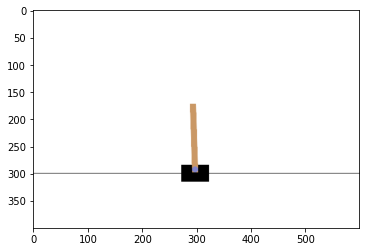

In [114]:
with gym.make("CartPole-v1", render_mode='rgb_array') as env:
    env.reset()
    plt.imshow(env.render()[0])

In [113]:
with gym.make("CartPole-v1", render_mode='human') as env:
    for e in range(2):
        state = env.reset()
        while True:
            probs, values = model.forward(state)
            state, reward, done, _ = env.step(torch.distributions.Categorical(probs).sample().item())
            env.render()
            if done:
                break

/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
